In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3


Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


# TEST QSH


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
#file = ipysh.abs_builddir+'/te_db_r15_clean_shuffle.npy'
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
try: qsh.load(file)
except: raise FileNotFoundError

# qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm','absBt_rm','argBt_rm']) 
print("QSH rebalanced 15 points size: ", len(qsh))




QSH rebalanced 15 points size:  47567


In [3]:
def _map(xy,p,Br):
    pBr = tf.concat([p,Br], axis=0)
    return pBr,xy

ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm~absBt_rm~argBt_rm']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

(<tf.Tensor: id=57, shape=(1, 44), dtype=float32, numpy=
 array([[0.5913013 , 0.7473015 , 0.7180505 , 0.5724611 , 0.250743  ,
         0.05380955, 0.02268622, 0.02692102, 0.01763678, 0.01286681,
         0.02506381, 0.03940256, 0.04795665, 0.05806868, 0.52077395,
         0.79967904, 0.39720488, 0.45643446, 0.41451785, 0.78297186,
         0.52624124, 0.7746366 , 0.9453669 , 0.18642354, 0.57343084,
         0.05692115, 0.04216208, 0.05203445, 0.02888104, 0.0421698 ,
         0.03562685, 0.03385055, 0.03195138, 0.02654408, 0.75487256,
         0.9368505 , 0.5767383 , 0.60964626, 0.65717685, 0.70399654,
         0.75998366, 0.98576516, 0.28438514, 0.40795994]], dtype=float32)>,
 <tf.Tensor: id=58, shape=(1, 30), dtype=float32, numpy=
 array([[0.06214391, 0.10277789, 0.15121816, 0.20828514, 0.27427357,
         0.3485927 , 0.42948723, 0.51404023, 0.59859335, 0.6794879 ,
         0.75380695, 0.8197954 , 0.8768625 ,        nan,        nan,
         0.37615946, 0.3215071 , 0.36501402, 0.3527

In [4]:
vae = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0.1, beta=0., scale=2, geometry=[20,20,10,10])
vae.compile( vae.optimizer, tf.losses.mse )

AEFIT5 ready:


In [5]:
dds = ds.map(lambda p,xy: (xy,xy))
vae_history = vae.fit( dds.skip(5000).batch(100, drop_remainder=True), validation_data=dds.take(5000).batch(100), epochs=50, shuffle=False)

Epoch 1/50
     54/Unknown - 5s 101ms/step - loss: 0.0140

KeyboardInterrupt: 

In [7]:
##### vae.save('step12_vae_ls_tesi') 
vae.load('../step12_vae_ls_tesi')

# vae.inference_net.get_config()
# tf.saved_model.save(vae.inference_net, '/tmp/thesis/vae/12_7/inference_net')
# cacca = tf.saved_model.load('/tmp/thesis/vae/12_7/inference_net')


In [9]:
pos = 0

6


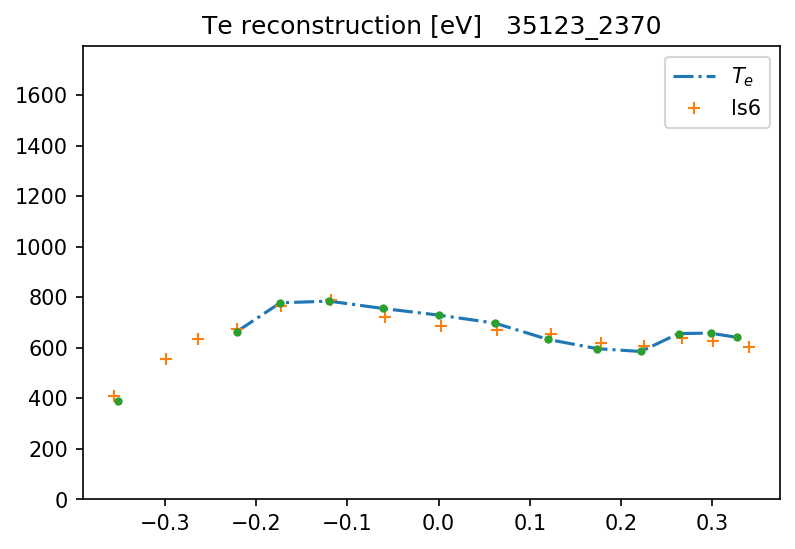

In [17]:
print(pos)

def un(x, min=0., max=2242.511):
    return min + x*(max-min)

def unx(x, min=-0.373, max=0.353):
    return min + x*(max-min)

def plot_tf(xy, name=None, h='.'):
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,un(0.8))
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(unx(x),un(y),h, label=name)
    ax.legend()

def plot(x,y, name=None, h='.'):  
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,un(0.8))
    plt.plot(unx(x),un(y), h, label=name)
    #ax.legend()
    
def plot_bar_x(index, w, title, w2=None):
    # this is for plotting purpose
    fig = plt.figure(title)
    plt.clf()
    fig.set_dpi(150)
    plt.bar(index, w, color='lightgrey', edgecolor='black')    
    # plt.ylabel('plasma parameters', fontsize=10)
    plt.xticks(index, fontsize=10)
    plt.title(title)
    return fig
    

def plot_te(pos):    
    d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]
    # path = '/home/andrea/Documents/phd/Thesis/img/STEP12/STEP12_7'
    p  = d_pos[0]
    xy = d_pos[1]

    fig = plt.figure('plot')
    plt.clf()
    # plt.text(0.05,0.7, '$I_p = %.2f$'%qsh[pos]['Ip'] )
    ax = plt.gca()
    ax.set_title( 'Te reconstruction [eV]   '+qsh[pos].label.decode("utf-8") )

    XY_vae = vae(xy, training=False)
#     ls = gen(d_pos[0], training=False)
#     XY = vae.decode(ls, training=False)
    # XY = tf.sigmoid(XY)
    plot_tf(xy, '$T_e$','-.')
    plot_tf(XY_vae, 'ls6','+')
#     plot_tf(XY, 'guess','x')
    plot(qsh[pos]['prel'],qsh[pos]['te'], '$T_c$')

    fig = plt.figure('plot')
    # fig.savefig( path+'/Te_rec_'+str(pos)+'.png')

# for pos in range(250):
#     plot_te(pos)
plot_te(pos)
pos = pos+1

In [ ]:
q = [q for q in ds.batch(2).take(1)][0]
q

In [ ]:
loss = {
    'mse' : [],
    'sum_e' : [],
#    'sum_ve': [],
    'max' : [],
    'min' : [],
    'Ip' : [],
    'NS' : [],
    'Vt' : [],
    'F'  : [],
}
fig = plt.figure()

def un(x, min, max):
    return min + x*(max-min)

for i,d_pos in enumerate(ds.batch(300).take(10)):
    p  = d_pos[0]
    xy = d_pos[1]
    XY_vae = vae(xy, training=False)
    ls = gen(d_pos[0], training=False)
    XY = vae.decode(ls, training=False)
    
    prel = tf.split(p, split_)
    
    mse = tf.losses.mse(XY_vae,XY)
    sum_e = tf.reduce_sum( (XY_vae-XY), axis=1) / 15
    max_e = tf.reduce_max( XY_vae-XY, axis=1) 
    min_e = tf.reduce_min( XY_vae-XY, axis=1) 
    # plot_tf(XY_vae, 'ls6','+')
    # plot_tf(XY, 'guess','x')
    for i in range(300):
        loss['mse'].append( un(mse[i].numpy(),0.,2242.511) )
        loss['sum_e'].append( un(sum_e[i].numpy(),0.,2242.511)  )
        loss['max'].append( un(max_e[i].numpy()-min_e[i].numpy(),0.,2242.511)  )
        loss['min'].append( un(min_e[i].numpy()-max_e[i].numpy(),0.,2242.511)  )
        loss['Ip'].append( un(p[i][0].numpy(),0.41,0.79) )
        loss['NS'].append( un(p[i][1].numpy(),2.55,7.69) )
        loss['Vt'].append( un(p[i][2].numpy(),161.15, 272.39) ) 
        loss['F'].append(p[i][3].numpy())
    

In [ ]:
import seaborn as sns
from scipy import stats

#x = np.clip( np.array(loss['sum_e']), a_min=-200., a_max=200. )
lim = 200.
lim_f = 200.
x = np.array(loss['sum_e'])
X_in  = x[ (x > -lim_f) & (x < lim_f) ]
X_out = x[ (x < -lim_f) | (x > lim_f) ]

ax = sns.distplot( x, kde=False ,norm_hist=True, hist_kws={"range": [-lim,lim], "histtype": "step", "linewidth": 2, "color": "k"} );

xx = np.arange(-lim,lim, 0.1)
mu,std = stats.norm.fit(X_in)
yy = stats.norm.pdf(xx,mu,std)
ax.plot(xx,yy,'--k', label='norm')

# mu,std = stats.logistic.fit(x)
# yy = stats.logistic.pdf(xx,mu,std)
# ax.plot(xx,yy,'-.r', label='N_2')


fig = plt.gcf()
fig.set_dpi(150)
plt.xlim(-190,190)
#plt.legend()

ax.set_title('mean SRX reconstruction error')

plt.text(100,0.006,'$\sigma = %.2f$\nKurt $= %.2f$'%(x.std(),stats.kurtosis(x)))

print('norm',stats.norm.fit(x))
print('kurt',stats.kurtosis(x))
print('logistic',stats.logistic.fit(x))

In [ ]:
import seaborn as sns
from scipy import stats

#x = np.clip( np.array(loss['sum_e']), a_min=-200., a_max=200. )
lim = 200.
x = loss['max']
# x = x[ x < lim ]
# x = x[ x > -lim ]

ax = sns.distplot( x, kde=False, norm_hist=True, hist_kws={"range": [-lim,lim]} );

xx = np.arange(-lim,lim, 0.1)
mu,std = stats.norm.fit(x)
yy = stats.norm.pdf(xx,mu,std)
ax.plot(xx,yy,'--k', label='norm')

mu,std = stats.logistic.fit(x)
yy = stats.logistic.pdf(xx,mu,std)
ax.plot(xx,yy,'-.r', label='logisitc')


fig = plt.gcf()
fig.set_dpi(150)
# plt.xlim(-190,190)
plt.legend()

ax.set_title('max SRX error distribution')
print('norm',stats.norm.fit(x))
print('logistic',stats.logistic.fit(x))

In [ ]:
print(len(loss['mse']))
fig = plt.figure('params vs mse')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Ip [MA] vs mse on reconstructed SXR')
# plt.yscale('log')
# plt.plot(loss['Ip'],loss['mse'],'+')
plt.plot(loss['Ip'],np.log(loss['max']),'x')
# plt.plot(loss['NS'],loss['mse'],'x')
# plt.plot(loss['Vt'],loss['mse'],'.')
# plt.plot(loss['F'],loss['mse'],'.')

fig = plt.figure('Ip hist')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Ip [MA] vs mse on reconstructed SXR')
plt.hist2d(loss['Ip'], np.log(loss['max']), (50, 50), cmap=plt.cm.jet)
# plt.hist2d(loss['Ip'], loss['sum_e'], (50, 50), cmap=plt.cm.jet)
# plt.colorbar()

In [ ]:
print(len(loss['mse']))
fig = plt.figure('params vs mse')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('NS vs mse on reconstructed SXR')
plt.yscale('log')
plt.plot(loss['NS'],loss['mse'],'+')


fig = plt.figure('NS hist')
ax = plt.gca()
ax.set_title('NS vs log(mse) on reconstructed SXR')
fig.set_dpi(150)
plt.hist2d(loss['NS'], np.log(loss['mse']), (50, 50), cmap=plt.cm.jet)
# plt.colorbar()
